# [Adult Data Analysis](https://www.kaggle.com/c/adult-pmr3508)

[PMR3508](https://uspdigital.usp.br/jupiterweb/obterDisciplina?sgldis=PMR3508) - Machine Learning and Pattern Recognition

Professor Fabio Gagliardi Cozman

PMR3508-2020-83 - [Vitor Gratiere Torres](https://github.com/vitorgt/PMR3508)

This analysis consists in predicting whether someone has an income greater or lesser than 50k with attributes like level of education, age, work class, occupation, among others, and will be based on 6 steps as follows:

1. [Import data and python modules](#1.-Import-data-and-python-modules)
2. [Factorize](#2.-Factorize)
3. [Data visualization and raw analysis](#3.-Data-visualization-and-raw-analysis)
4. [Data selection](#4.-Data-selection)
5. [Training and discovering ```k```](#5.-Training-and-discovering-k)
6. [Predicting](#6.-Predicting)

## 1. Import data and python modules

In [1]:
import csv
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

adultNA = pd.read_csv(
    "adult-pmr3508/train_data.csv", index_col=["Id"], na_values="?"
)
adultTest = pd.read_csv(
    "adult-pmr3508/test_data.csv", index_col=["Id"], na_values="?"
)

print("Adult with NA shape:", adultNA.shape)
print("Adult testing shape:", adultTest.shape)

adultNA.head()

Adult with NA shape: (32560, 15)
Adult testing shape: (16280, 14)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


## 2. Factorize

Encode objects as an enumerated type or categorical variable. This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values.

Note: ```education``` is already factorized in ```education.num```. I've followed the same nomenclature for the following features while storing them on ```uniques``` for further reference.

In [2]:
uniques = {
    "workclass": [],
    "marital.status": [],
    "occupation": [],
    "relationship": [],
    "race": [],
    "sex": [],
    "native.country": [],
    "income": [],
}

uniquesTest = {}

for keys in uniques:
    adultNA.loc[:, (keys + ".num")], uniques[keys] = pd.factorize(
        adultNA.loc[:, (keys)], sort=True
    )
    if keys != "income":
        (
            adultTest.loc[:, (keys + ".num")],
            uniquesTest[keys],
        ) = pd.factorize(adultTest.loc[:, (keys)], sort=True)

## 3. Data visualization and raw analysis

In [3]:
adultNA.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass.num,marital.status.num,occupation.num,relationship.num,race.num,sex.num,native.country.num,income.num
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469,2.868796,2.611794,5.572912,1.446376,3.665848,0.669195,35.718796,0.240817
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618,1.455879,1.506225,4.228809,1.606794,0.848817,0.470510,7.823892,0.427586
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000,3.000000,2.000000,2.000000,0.000000,4.000000,0.000000,38.000000,0.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000,3.000000,2.000000,6.000000,1.000000,4.000000,1.000000,38.000000,0.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000,3.000000,4.000000,9.000000,3.000000,4.000000,1.000000,38.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,7.000000,6.000000,13.000000,5.000000,4.000000,1.000000,40.000000,1.000000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>,
        <AxesSubplot:title={'center':'education.num'}>,
        <AxesSubplot:title={'center':'capital.gain'}>],
       [<AxesSubplot:title={'center':'capital.loss'}>,
        <AxesSubplot:title={'center':'hours.per.week'}>,
        <AxesSubplot:title={'center':'workclass.num'}>,
        <AxesSubplot:title={'center':'marital.status.num'}>],
       [<AxesSubplot:title={'center':'occupation.num'}>,
        <AxesSubplot:title={'center':'relationship.num'}>,
        <AxesSubplot:title={'center':'race.num'}>,
        <AxesSubplot:title={'center':'sex.num'}>],
       [<AxesSubplot:title={'center':'native.country.num'}>,
        <AxesSubplot:title={'center':'income.num'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

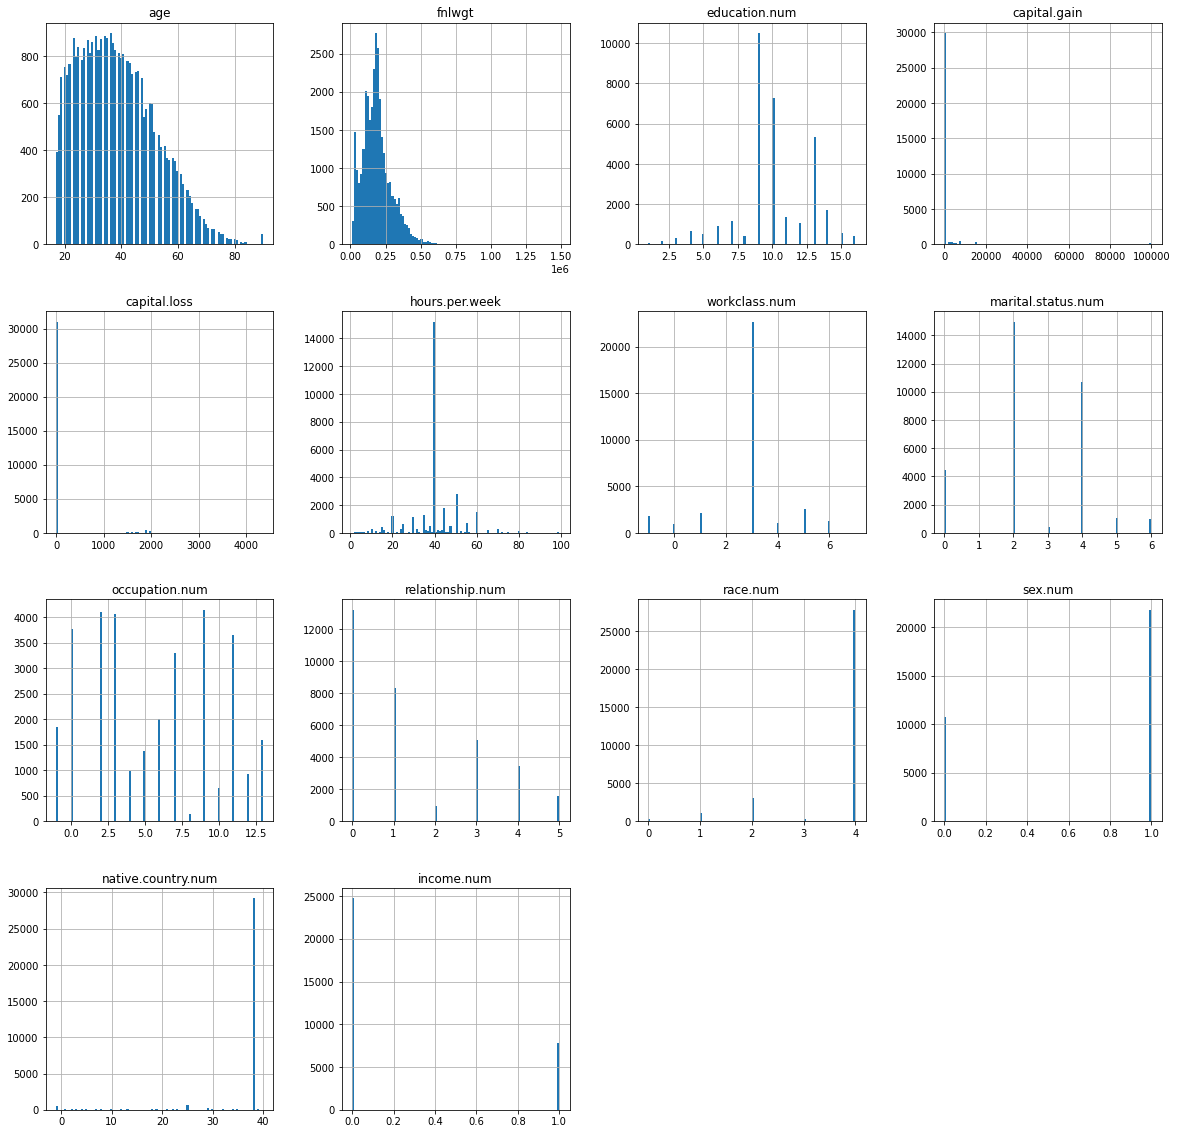

In [4]:
adultNA.hist(bins=100, figsize=(20, 20))

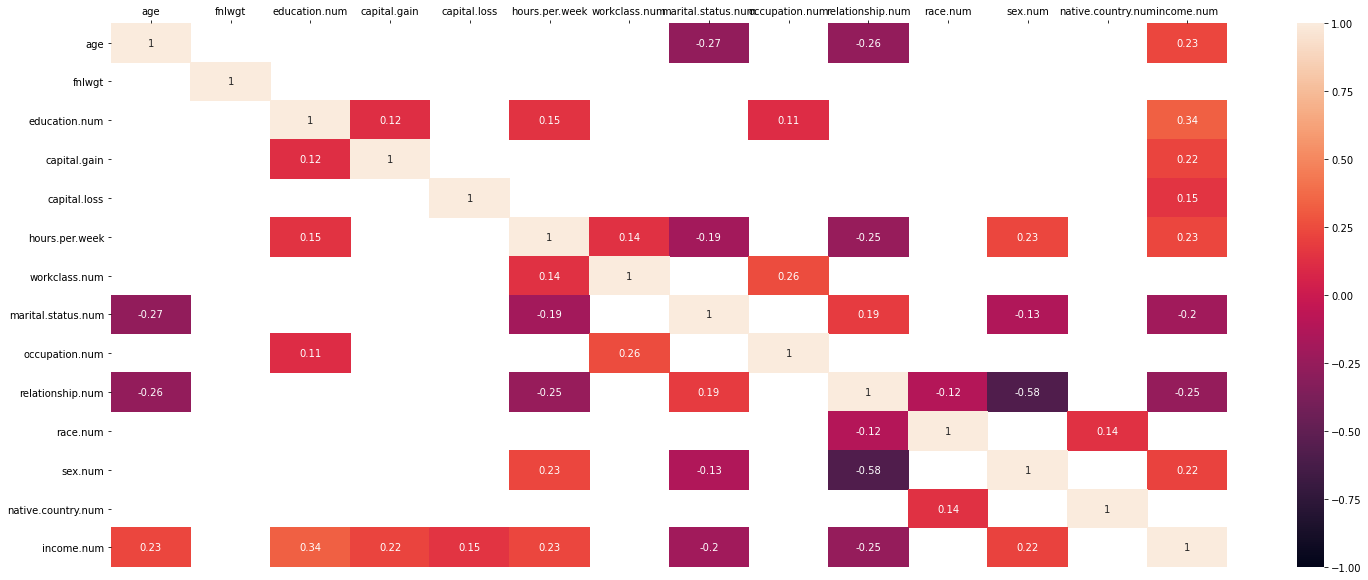

In [5]:
corrmat = adultNA.corr()
threshold = 0.1
plt.figure(figsize=(25, 10))
sns.heatmap(
    corrmat[abs(corrmat[:]) > threshold],
    vmax=1.0,
    vmin=-1.0,
    annot=True,
).xaxis.tick_top()

```income``` is most correlated to ```age```, ```education```, ```capital.gain```, ```capital.loss```, ```hours.per.week```, ```maritial.status```, ```relationship``` and ```sex```.

I thought ```occupation``` would be more correlated to ```income``` for it to make sense logically, numbers show otherwise though. I think it may be because ```occupation``` and ```occupation.num``` are randomly sorted, if it were sorted by job's payment, I think it might find a bigger correlation. So, I'll create a knn classifier with and another without it.

<Figure size 1440x1440 with 0 Axes>

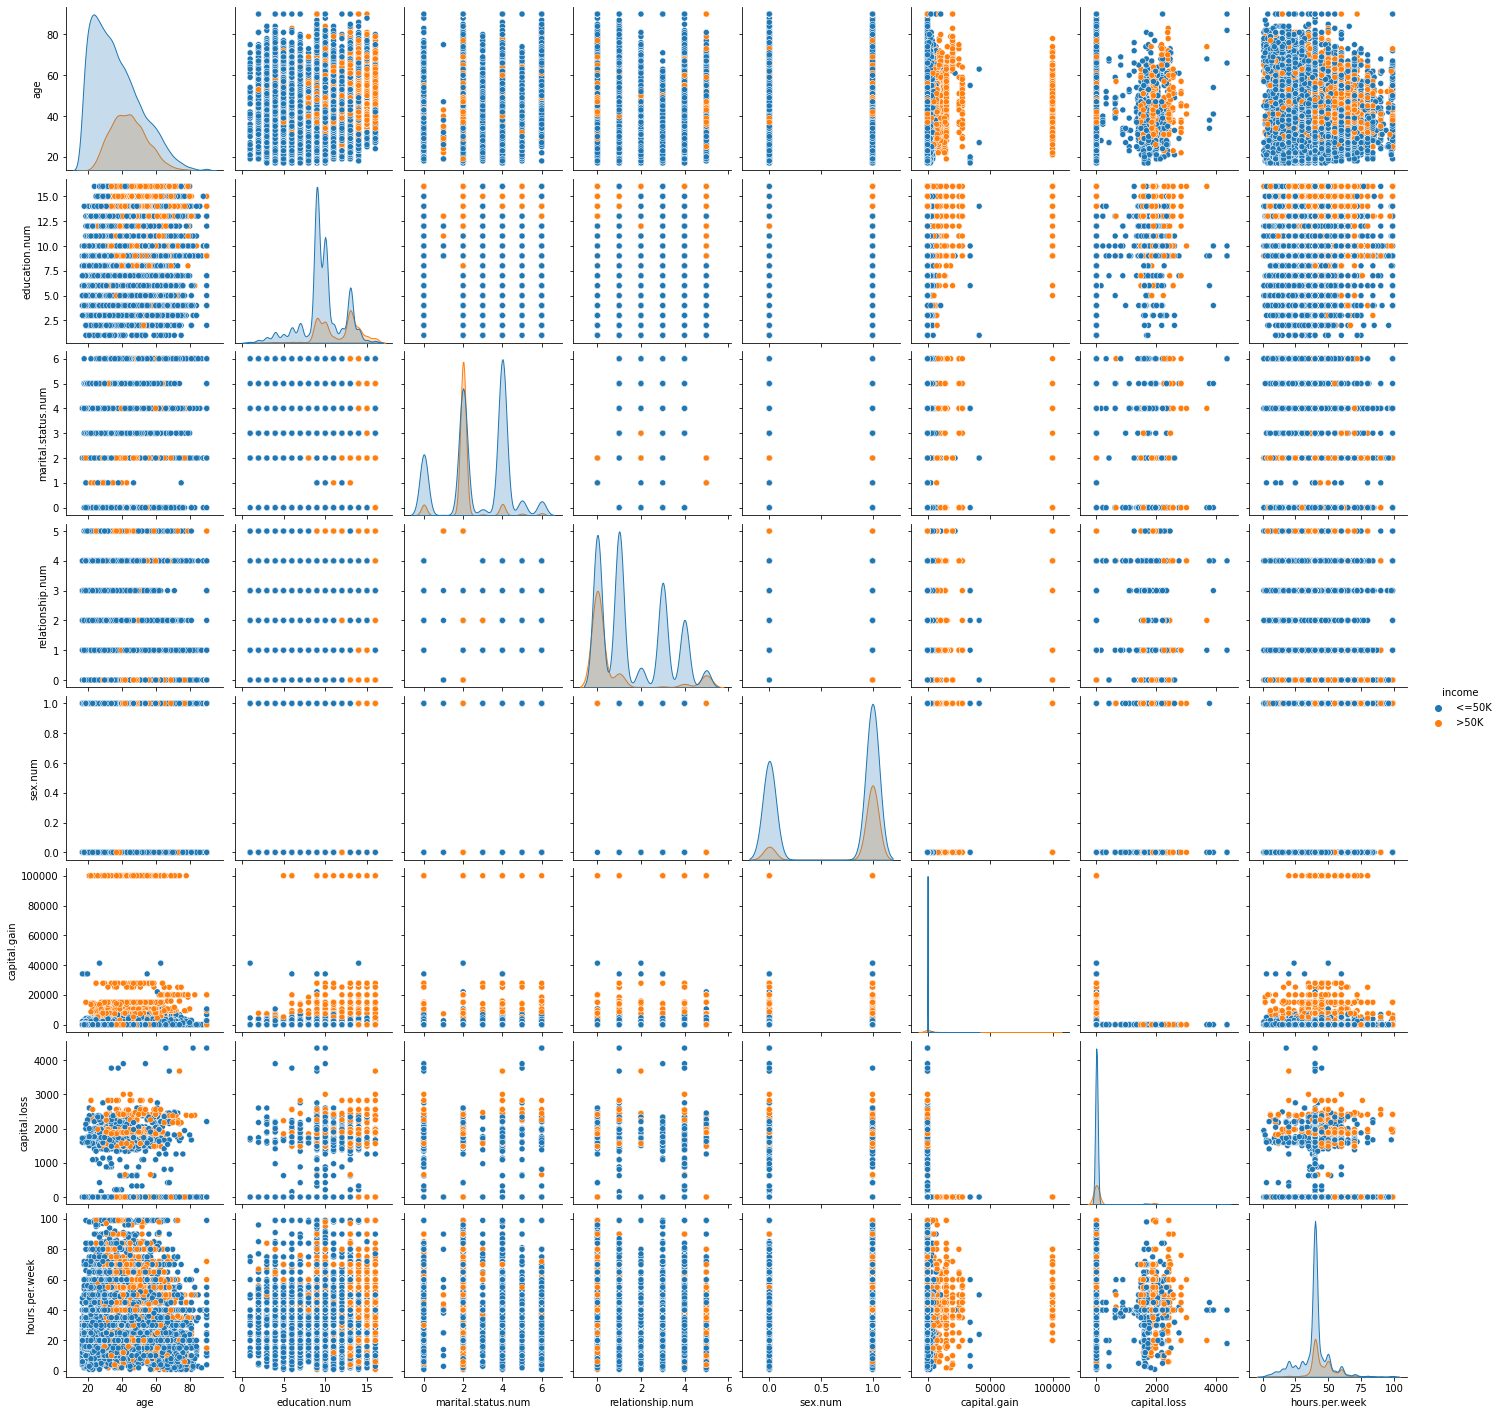

In [6]:
plt.figure(figsize=(20, 20))
sns.pairplot(
    adultNA,
    vars=[
        "age",
        "education.num",
        "marital.status.num",
        "relationship.num",
        "sex.num",
        "capital.gain",
        "capital.loss",
        "hours.per.week",
    ],
    hue="income",
)

Note that ```native.country``` brings no relevant information since 91% of its data represents the same group.

In [7]:
adultNA.loc[:, ("native.country")].value_counts(normalize=True)

United-States                 0.912187
Mexico                        0.020108
Philippines                   0.006192
Germany                       0.004284
Canada                        0.003784
Puerto-Rico                   0.003565
El-Salvador                   0.003315
India                         0.003127
Cuba                          0.002971
England                       0.002815
Jamaica                       0.002533
South                         0.002502
China                         0.002345
Italy                         0.002283
Dominican-Republic            0.002189
Vietnam                       0.002095
Guatemala                     0.002001
Japan                         0.001939
Poland                        0.001876
Columbia                      0.001845
Taiwan                        0.001595
Haiti                         0.001376
Iran                          0.001345
Portugal                      0.001157
Nicaragua                     0.001063
Peru                     

## 4. Data selection

First I've decided to drop entries with missing data because 1 they were just a few, 2 it brought no meaningful data.

In [8]:
adult = adultNA.dropna()

print("Adult with NA shape:", adultNA.shape)
print("Adult without NA shape:", adult.shape)

Adult with NA shape: (32560, 23)
Adult without NA shape: (30161, 23)


In [9]:
X1adult = adult.loc[
    :,
    (
        "age",
        "education.num",
        "marital.status.num",
        "relationship.num",
        "sex.num",
        "capital.gain",
        "capital.loss",
        "hours.per.week",
    ),
]

# this second classifier will have two classes more: 'race' and 'occupation'
X2adult = adult.loc[
    :,
    (
        "age",
        "education.num",
        "marital.status.num",
        "relationship.num",
        "sex.num",
        "capital.gain",
        "capital.loss",
        "hours.per.week",
        "race.num",
        "occupation.num",
    ),
]

Yadult = adult.loc[:, ("income")]

testX1adult = adultTest.loc[
    :,
    (
        "age",
        "education.num",
        "marital.status.num",
        "relationship.num",
        "sex.num",
        "capital.gain",
        "capital.loss",
        "hours.per.week",
    ),
]

testX2adult = adultTest.loc[
    :,
    (
        "age",
        "education.num",
        "marital.status.num",
        "relationship.num",
        "sex.num",
        "capital.gain",
        "capital.loss",
        "hours.per.week",
        "race.num",
        "occupation.num",
    ),
]

## 5. Training and discovering ```k```

In [10]:
%%time

knn = {"best": {"score": 0, "k": 0}}

for k in range(10, 28):
    knn[k] = {}
    knn[k]["classifier"] = KNeighborsClassifier(k, metric="manhattan")
    knn[k]["score"] = np.mean(
        cross_val_score(
            knn[k]["classifier"],
            X2adult,
            Yadult,
            cv=10,
            scoring="accuracy",
        )
    )
    if knn[k]["score"] > knn["best"]["score"]:
        knn["best"]["score"] = knn[k]["score"]
        knn["best"]["k"] = k


knn[knn["best"]["k"]]["classifier"].fit(X2adult, Yadult)

print("Best accuracy:", knn["best"]["score"], "K =", knn["best"]["k"])

Best accuracy: 0.8541827741823742 K = 21
CPU times: user 3min 35s, sys: 40.4 ms, total: 3min 35s
Wall time: 3min 34s


Now, this table describes my iteration process to find the best ```k```.

| Iteration | Range iterated         |   Data frame  | ```k``` | Accuracy |
|:---------:|:-----------------------|:-------------:|:-------:|:--------:|
|     1     | ```range(10, 55, 5)``` | ```X1adult``` |    30   |  0.8512  |
|     2     | ```range(25, 36)```    | ```X1adult``` |    28   |  0.8516  |
|     3     | ```range(10, 55, 5)``` | ```X2adult``` |    15   |  0.8539  |
|     4     | ```range(10, 21)```    | ```X2adult``` |    15   |  0.8539  |
|     5     | ```range(10, 28)```    | ```X2adult``` |    21   |  0.8541  |

The second data frame (with ```occupation``` and ```race```) is yielding a better accuracy, as it logically (and sadly) should, given our context.

## 6. Predicting

In [11]:
%%time

prediction = knn[knn["best"]["k"]]["classifier"].predict(testX2adult)

CPU times: user 3.83 s, sys: 9.87 ms, total: 3.84 s
Wall time: 3.84 s


## Exporting and submitting

In [12]:
result = pd.DataFrame({"income": prediction})
result.to_csv("submission.csv", index=True, index_label="Id")
result

,income
0,<=50K
1,>50K
2,<=50K
3,<=50K
4,>50K
...,...
16275,<=50K
16276,<=50K
16277,<=50K
16278,<=50K


# Thank you :)